# K - clustering for edge devices
## Tables of contents
### 1.Feature Definition and Data Collection
- Select measurable features suitable for edge devices .
- Collect data from devices or public datasets.
- Normalize and store data efficiently for limited hardware.
### 2. K-Means Classification on Edge Devices
- Implement a lightweight K-Means algorithm optimized for CPU/GPU constraints.
- Data Standardization.
- Finding Optimal Number of Clusters
  + Elbow Method.
  + Silhouette Score.
- PCA for Visualization.
- Saving and Exporting Results.
- Demonstration: Mango classification using the [dataset](https://www.kaggle.com/code/muhammadmuzammil196/k-mean-mangoes-clustering).
### 3. Integration with Split Inference
- Extract features on the edge device to minimize bandwidth.
- Perform clustering locally for real-time classification.
- Offload model retraining to the cloud.
- Synchronize updated cluster centers back to devices with minimal data transfer.


### 1. Define feature and collect data

### 2. Build algorithm

In [34]:
# ==========================================================
# 1. IMPORT LIBRARIES
# ==========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [35]:
# ==========================================================
# 2. LOAD DATA
# ==========================================================
df = pd.read_csv("Devices2.csv")
display(Markdown("### 🟩 Dữ liệu đầu vào"))
display(df.head())
print(df.shape)


### 🟩 Dữ liệu đầu vào

,CPU,ATRam,ATStorage,Internet
0,0.051471,0.930540,0.743450,0.090909
1,0.169118,0.783511,0.672414,0.000000
2,0.044118,0.808952,0.724138,0.090909
3,0.044118,0.323077,0.542373,0.000000
4,0.316176,0.589744,0.110000,0.090909


(18, 4)


In [36]:
# ==========================================================
# 3. TIỀN XỬ LÝ (XỬ LÝ NA, LỌC CỘT SỐ)
# ==========================================================
df = df.dropna()

# Lấy các cột dạng numeric để phân cụm
num_df = df.select_dtypes(include=[np.number])

display(Markdown("### 🟦 Dữ liệu số dùng để phân cụm"))
display(num_df.head())


### 🟦 Dữ liệu số dùng để phân cụm

,CPU,ATRam,ATStorage,Internet
0,0.051471,0.930540,0.743450,0.090909
1,0.169118,0.783511,0.672414,0.000000
2,0.044118,0.808952,0.724138,0.090909
3,0.044118,0.323077,0.542373,0.000000
4,0.316176,0.589744,0.110000,0.090909


In [37]:
# ==========================================================
# 4. CHUẨN HÓA (VERY IMPORTANT FOR K-MEANS)
# ==========================================================
scaler = StandardScaler()
X = scaler.fit_transform(num_df)


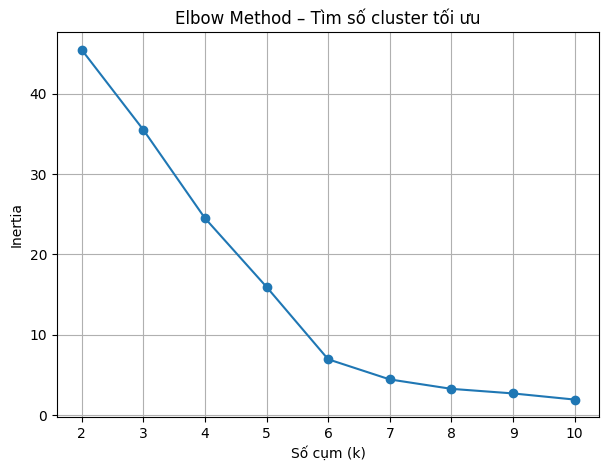

In [38]:
# ==========================================================
# 5. TÌM SỐ CLUSTER TỐI ƯU (ELBOW METHOD)
# ==========================================================
inertias = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(7,5))
plt.plot(K, inertias, marker='o')
plt.title("Elbow Method – Tìm số cluster tối ưu")
plt.xlabel("Số cụm (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


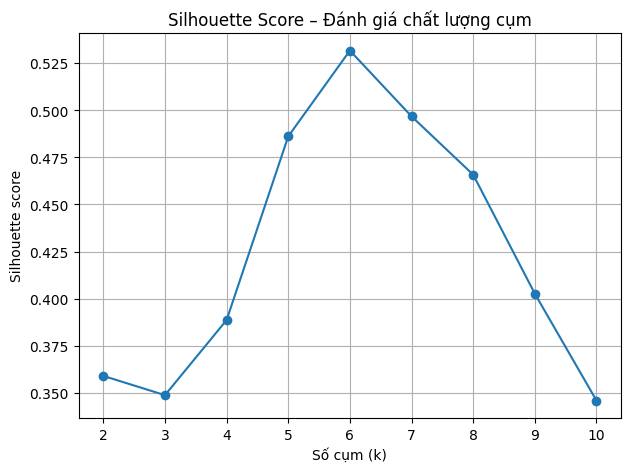

In [39]:
# ==========================================================
# 6. SILHOUETTE SCORE – KIỂM TRA CHẤT LƯỢNG CỤM
# ==========================================================
sil_scores = []

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X)
    sil = silhouette_score(X, labels)
    sil_scores.append(sil)

plt.figure(figsize=(7,5))
plt.plot(K, sil_scores, marker='o')
plt.title("Silhouette Score – Đánh giá chất lượng cụm")
plt.xlabel("Số cụm (k)")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()


In [40]:
# ==========================================================
# 7. CHỌN K TỐI ƯU
# (Tự động lấy k có silhouette cao nhất)
# ==========================================================
best_k = K[np.argmax(sil_scores)]
best_k


6

In [41]:
# ==========================================================
# 8. TRAIN K-MEANS VỚI K TỐI ƯU
# ==========================================================
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(X)

df["Cluster"] = clusters

display(Markdown(f"### 🟨 Số cụm tối ưu: **{best_k}**"))
display(df.head())


### 🟨 Số cụm tối ưu: **6**

,CPU,ATRam,ATStorage,Internet,Cluster
0,0.051471,0.930540,0.743450,0.090909,2
1,0.169118,0.783511,0.672414,0.000000,2
2,0.044118,0.808952,0.724138,0.090909,2
3,0.044118,0.323077,0.542373,0.000000,5
4,0.316176,0.589744,0.110000,0.090909,0


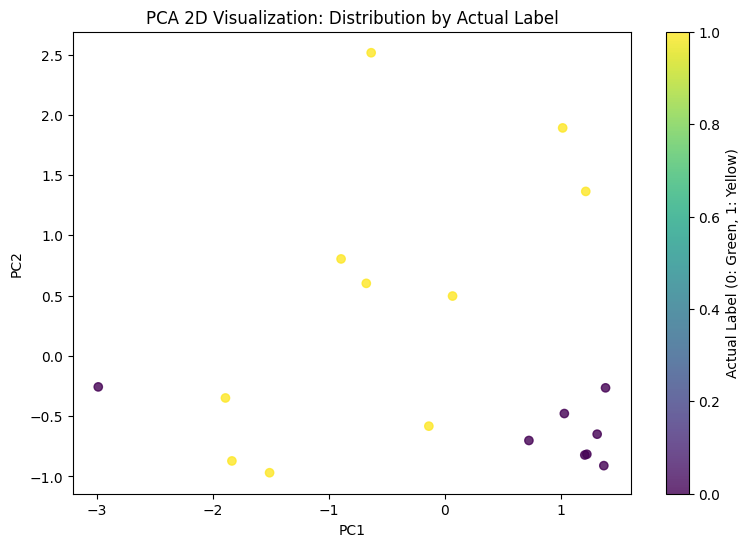

In [42]:

# ==========================================================
# 9. CHUẨN BỊ, PCA VÀ CHIA TẬP DỮ LIỆU
# ==========================================================
# Đảm bảo df được load (Giả sử file là mango2.csv)
try:
    df = pd.read_csv('Devices.csv')
except FileNotFoundError:
    print("LỖI: Không tìm thấy file 'Devices2.csv'.")
    exit()
# 1. TẠO LABEL GỐC (Ground Truth)
df["Label"] = (
    (df["CPU"] + df["ATRam"]) >
    (df["ATStorage"] + df["Internet"])
).astype(int)

# 2. Lấy 4 Features Gốc (X4)
X4 = df[["CPU", "ATRam",
        "ATStorage", "Internet"]].values

# 3. Chuẩn hóa & PCA
scaler_pca = StandardScaler()
X4_scaled = scaler_pca.fit_transform(X4)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X4_scaled) # <-- Dữ liệu 2D (PC1, PC2)

# 4. Gán Features PCA vào DataFrame
df["Efficiency"] = X_pca[:, 0] # PC1
df["Speed"] = X_pca[:, 1]  # PC2

# ==========================================================
# BƯỚC MỚI: VẼ HÌNH PCA 2D NGAY SAU KHI TÍNH
# ==========================================================
plt.figure(figsize=(9, 6))
# Sử dụng PC1 (Length) và PC2 (Width) để vẽ
# Tô màu dựa trên nhãn gốc (Label)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df["Label"], cmap='viridis', alpha=0.8)
plt.title("PCA 2D Visualization: Distribution by Actual Label")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Actual Label (0: Green, 1: Yellow)")
plt.show()

# ==========================================================
# 5. CHIA TẬP DỮ LIỆU SỬ DỤNG PCA FEATURES (Length/Width)
# ==========================================================
X = df[["Efficiency", "Speed"]].values
Y = df["Label"].values

x_train, x_test, y_train, y_test = train_test_split(
    X, Y,
    test_size=0.3,
    random_state=42
)

# Khai báo biến thiếu (Sửa lỗi NameError)
devices_train = y_train
devices_test = y_test

In [43]:
# ==========================================================
# 10. HÀM K-MEANS THỦ CÔNG
# ==========================================================

def manual_kmeans(X, k=6, max_iter=100):
    # Khởi tạo tâm cụm ngẫu nhiên
    init_centers = X[np.random.choice(len(X), k, replace=False)].copy()
    centers = init_centers.copy()

    for _ in range(max_iter):
        # --- ASSIGN STEP ---
        clusters = [[] for _ in range(k)]
        for point in X:
            # Tìm tâm gần nhất (2D)
            idx = np.argmin(np.linalg.norm(point - centers, axis=1))
            clusters[idx].append(point)

        # --- UPDATE STEP ---
        new_centers = np.array([np.mean(c, axis=0) if len(c) > 0 else centers[i]
                                for i, c in enumerate(clusters)])

        # Kiểm tra điều kiện dừng
        if np.allclose(new_centers, centers):
            break
        centers = new_centers.copy()

    return centers, clusters, init_centers

def nearest_point(points, center):
    # Tìm điểm huấn luyện gần nhất với tâm cụm (cho việc ánh xạ nhãn)
    return min(points, key=lambda p: np.linalg.norm(p - center))

def get_center_id(point, centers):
    # Tìm ID của tâm cụm gần nhất
    return np.argmin(np.linalg.norm(centers - point, axis=1))

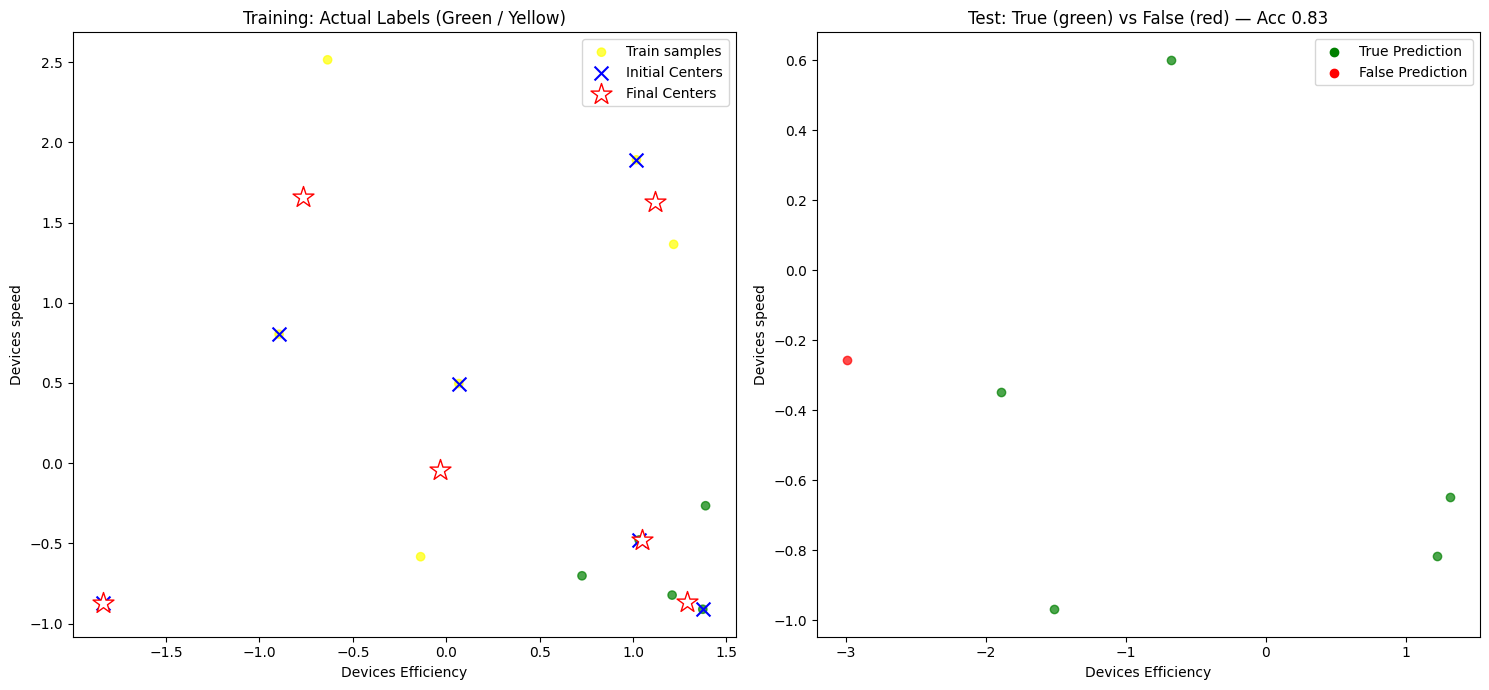

True Predictions: 5, False Predictions: 1
Accuracy: 0.83


In [44]:
# ==========================================================
# 11. HÀM TEST_KMEANS VÀ TRỰC QUAN HÓA
# ==========================================================
def test_kmeans(x_train, y_train, x_test, y_test):

    num_clusters = 6
    max_iterations = 100

    # 1. Huấn luyện trên tập TRAIN (Sử dụng dữ liệu PCA 2D)
    centers, _, init_centers = manual_kmeans(x_train, k=num_clusters, max_iter=max_iterations)

    # 2. ÁNH XẠ TÂM CỤM → NHÃN GỐC (MAP CENTER → LABEL)
    # Gán nhãn cho mỗi tâm cụm bằng cách tìm nhãn gốc của điểm huấn luyện gần nhất.
    pred_center_labels = []

    for c in centers:
        # Tìm điểm huấn luyện gần tâm cụm nhất
        nearest = nearest_point(x_train, c)

        # Tìm index của điểm đó trong tập huấn luyện
        idx = np.where(np.all(x_train == nearest, axis=1))[0][0]

        # Gán nhãn gốc của điểm huấn luyện đó cho tâm cụm
        pred_center_labels.append(y_train[idx])

    # 3. PLOT (Vẽ sơ đồ Train/Test)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))

    # --- TRAINING FIGURE (LEFT) ---
    # Màu dựa trên nhãn gốc (0: Xanh, 1: Vàng)
    train_colors = ['Green' if m == 0 else 'Yellow' for m in y_train]

    ax0.scatter(x_train[:, 0], x_train[:, 1], color=train_colors, alpha=0.7, label="Train samples")
    ax0.scatter(init_centers[:, 0], init_centers[:, 1], color='blue', marker='x', s=100, label="Initial Centers")
    ax0.scatter(centers[:, 0], centers[:, 1], color='white', edgecolor='red', marker='*', s=250, label="Final Centers")

    ax0.set_title("Training: Actual Labels (Green / Yellow)")
    ax0.set_xlabel("Devices Efficiency")
    ax0.set_ylabel("Devices speed")
    ax0.legend()

    # --- TEST FIGURE (RIGHT) & TÍNH ACCURACY ---
    true_predict = 0
    false_predict = 0

    for i in range(len(x_test)):
        p = x_test[i]         # Điểm kiểm tra
        cid = get_center_id(p, centers) # Tâm cụm gần nhất
        pred_label = pred_center_labels[cid] # Nhãn dự đoán từ tâm cụm

        if pred_label == y_test[i]:
            color = 'Green' # Dự đoán đúng (Green)
            true_predict += 1
        else:
            color = 'Red' # Dự đoán sai (Red)
            false_predict += 1

        ax1.plot(x_test[i, 0], x_test[i, 1], 'o', color=color, alpha=0.7)

    acc = true_predict / (true_predict + false_predict)

    ax1.set_title(f"Test: True (green) vs False (red) — Acc {acc:.2f}")
    ax1.set_xlabel("Devices Efficiency")
    ax1.set_ylabel("Devices speed")

    # Tạo chú thích cho biểu đồ Test
    ax1.scatter([], [], color='Green', label="True Prediction")
    ax1.scatter([], [], color='Red', label="False Prediction")
    ax1.legend()

    plt.tight_layout()
    plt.show()

    print(f"True Predictions: {true_predict}, False Predictions: {false_predict}")
    print(f"Accuracy: {acc:.2f}")


# ============================================
# THỰC THI (Run)
# ============================================
test_kmeans(x_train, y_train, x_test, y_test)